# Relevance score threshold

Dominika Tkaczyk

13.10.2018

This file contains the analysis of the meta-parameter (the relevance score threshold) of the search-based reference matching algorithm (SBM).

SBM is a very simple algorithm, based on the search functionality of Crossref REST API. It uses the search engine to find the target document for the given bibliographic reference string. The entire reference string is used as a query in the search engine. SBM returns the first hit from the results list, if its relevance score is high enough. If the relevance score of the first hit is low, null value is returned and the reference string stays unmatched.

The goal of this analysis is to find a good way to decide whether the top hit should be accepted as the target document, i.e. whether its relevance score is high enough.

## TL;DR

  * I used two datasets: a large dataset with automatically generated reference strings and a semi-manually annotated small dataset containing reference strings from the live system.
  * I investigated the tradeoff between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). The best value of a threshold is always chosen as the one maximizing the overall [F1](https://en.wikipedia.org/wiki/F1_score). F1 is a standard metric that combines precision and recall into a single number, weighing them equally.
  * I tested two variants of the threshold:
    * simple threshold (comparing the relevance score with a single number)
    * normalized threshold (comparing the relevance score divided by the length of the reference string with a single number)
  * The best value of the simple threshold is 53 for the automatically generated strings and 64 for the real dataset.
  * The best value of the normalized threshold is 0.47 for the automatically generated strings and 0.42 for the real dataset.
  * Using the normalized threshold is the better choice: the best normalized threshold outperforms the best simple threshold in overall F1 (70.43% vs. 67.21% for automatically generated strings and 90.27% vs. 86.98%), as well as F1 for each citation style.

## Methodology

In the simplest approach, SBM compares the item's relevance score with the relevance score threshold, and the item is accepted if its score exceeds the threshold. Note that if the threshold is small, the algorithm will return more matches, some correct and some incorrect. As a result more true links will be discovered, but at the same time we will have more incorrect links (more false positives). On the other hand, if the score threshold is large, we will have fewer matches overall. This means fewer true links discovered (more false negatives), but also fewer incorrect links.

To explore, how the value or values of the threshold affect the quality, we will need two things: the metrics and the dataset.

### Metrics

The rate of false positives and false negatives can be controlled by precision and recall, respectively:
  * **precision** is the number of correct links divided by the number of links returned by the algorithm (equivalently: the probability that the link returned by the algorithm is correct)
  * **recall** is the number of correct links divided by the number of true links (equivalently: the probability that the true link will be returned by the algorithm)

There is a tradeoff between precision and recall: we can always have higher recall at the price of lower precision, and vice versa. A standard way to control this is by combining precision and recall into one metric: F-measure. F-measure lets us weigh precision and recall accordingly to our application. For example, if we decide that it is more important to have more links discovered and we are willing to pay for it with more incorrect links, we would weight precision and recall differently in F-measure. In these experiments, however, I assume precision and recall have the same importance. This balanced version of F-measure is called **F1**, and is a simple harmonic mean of precision and recall.

### Datasets

The main dataset was build automatically:
  1. I randomly took two samples of documents from the system, each of size 2500:
    * Sample #1 is a regular sample, and any reference string generated from a document in this sample is expected to be linked to the original document.
    * Sample #2 contains documents that we exclude (or rather pretend to exclude) from the collection. A reference string generated from a document in this sample is expected not to be linked to anything.
  2. For each document in both samples, I generated the reference strings in 8 citation styles (*american-chemical-society*, *american-institute-of-physics*, *apa*, *chicago-author-date*, *elsevier-without-titles*, *harvard3*, *ieee*, *modern-language-association*). This resulted in 40,000 reference strings in total.
  3. I used SBM algorithm to find target documents for each generated reference string. The algorithm works as described before, but it pretends not to see the documents from sample #2 in the results, so they are never returned. More specifically, the algorithm returns the first item from the results, such that is doesn't belong to sample #2. If no such document exists, the algorithm returns null and the reference string is not linked. No threshold was used at this point, but all relevance scores were recorded, making it possible to modify the dataset later according to any filtering method.

Note that a more exact approach would be to build the search index without our "excluded" sample, instead of pretending they are not a part of the search results. This way we would be sure that the presence of these documents did not affect the scores in the system (especially the IDFs). On the other hand, it is unlikely that the absence of this sample will change the scores a lot.

In addition, I use a small dataset created semi-automatically. The dataset is based on a sample of 1000 real reference strings from the live system. All reference strings were matched using both SBM and the current reference matching algorithm (STQ, Simple Text Query). The ground truth DOIs were assigned in the following way:
  * if DOIs returned by STQ and SBM are the same, I assume it is correct and assign it to the document as the ground truth DOI
  * if DOIs returned by STQ and SBM are different, both were inspected manually:
    * if one of them was correct, it was assigned to the document as the ground truth DOI
    * if none of them was correct, I assume no target DOI exists
  * if only SBM returned the DOI, it was manually verified:
    * if correct, it was assigned to the document as the ground truth DOI
    * if incorrect, I assume no target DOI exists

## Results

In [1]:
import sys
sys.path.append('..')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from evaluation.link_metrics import LinkMetricsResults
from utils.utils import read_json, remote_call

DATA_DIR = '../data/relevance_threshold/'
STYLES = ['apa', 'american-chemical-society', 'american-institute-of-physics', 'chicago-author-date',
          'elsevier-without-titles', 'harvard3', 'ieee', 'modern-language-association']
STYLES_ABR = ['apa', 'acs', 'aip', 'chicago', 'ewt', 'harvard', 'ieee', 'mla']

### Artificial dataset

Let's read the data first:

In [2]:
def read_artificial_data():
    data = []
    for style in STYLES:
        data.extend(read_json(DATA_DIR + 'matched/matched-2500-' + style + '.json')[dfk.DATASET_DATASET])
        data.extend(read_json(DATA_DIR + 'matched/matched-excluded-2500-' + style + '.json')[dfk.DATASET_DATASET])
    return data

dataset = read_artificial_data()
print('Dataset size: {}'.format(len(dataset)))

Dataset size: 40000


By default SBM did not applied any threshold. What are precision, recall and F1 if we accept any top hit from the search results?

In [3]:
results_links = LinkMetricsResults(dataset)
print('Precision: {:.4f}'.format(results_links.get(dfk.EVAL_PREC)))
print('Recall: {:.4f}'.format(results_links.get(dfk.EVAL_REC)))
print('F1: {:.4f}'.format(results_links.get(dfk.EVAL_F1)))

Precision: 0.4535
Recall: 0.8859
F1: 0.5999


As expected, we have high recall, but low precision. The reason is that without the threshold the algorithm returns more links, both correct and incorrect.

#### Simple threshold

Let's assume we want to compare the item's relevance score with a simple threshold. We will investigate, how changing this simple threshold affects the overall quality.

This function will modify the dataset according to the threshold value:

In [4]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Let's now calculate and plot precision, recall and F1 for a range of different threshold values.

In [5]:
dataset = read_artificial_data()
results_simple_threshold = [(t, LinkMetricsResults(modify_simple_threshold(dataset, t))) for t in range(150)]

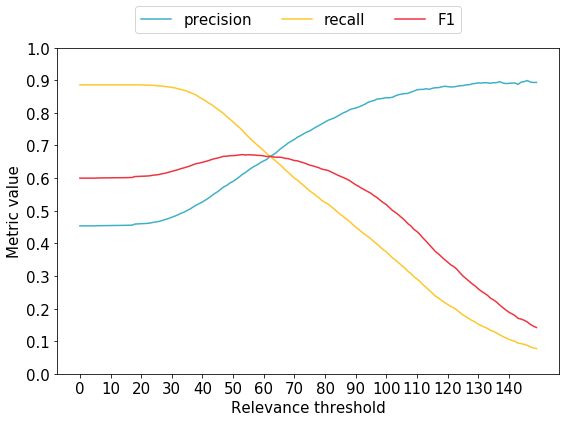

In [6]:
def plot_results(results):
    thresholds = [r[0] for r in results]
    results = [r[1] for r in results]
    plt.figure(figsize=(9,6))
    plt.rcParams.update({'font.size': 15})
    plt.plot(thresholds, [r.get(dfk.EVAL_PREC) for r in results], color='#3eb1c8')
    plt.plot(thresholds, [r.get(dfk.EVAL_REC) for r in results], color='#ffc72c')
    plt.plot(thresholds, [r.get(dfk.EVAL_F1) for r in results], color='#ef3340')
    plt.xticks(thresholds[0::10])
    plt.yticks([i / 10 for i in range(11)])
    plt.legend(['precision', 'recall', 'F1'], bbox_to_anchor=(0.82, 1.15), ncol=3)
    plt.xlabel('Relevance threshold')
    plt.ylabel('Metric value')
    plt.show()

plot_results(results_simple_threshold)

As expected, as we increase the threshold, precision goes up and recall goes down. Which threshold results in the best F1?

In [7]:
def find_best(results):
    overall = [r[1].get(dfk.EVAL_F1) for r in results]
    index = overall.index(max(overall))
    return index, results[index][0], \
        results[index][1].get(dfk.EVAL_PREC), results[index][1].get(dfk.EVAL_REC), results[index][1].get(dfk.EVAL_F1)

def print_best(results):
    index, threshold, precision, recall, f1 = find_best(results)
    print('Maximum F1 ({:.4f}) is for threshold {}'.format(f1, threshold))
    print('Precision for this threshold: {:.4f}'.format(precision))
    print('Recall for this threshold: {:.4f}'.format(recall))

print_best(results_simple_threshold)

Maximum F1 (0.6721) is for threshold 53
Precision for this threshold: 0.6112
Recall for this threshold: 0.7466


We can see that threshold 53 results in the best F1 (67.21%), but at the same time precision and recall and not very well balanced. One could argue it is better to choose the threshold that brings precision and recall close together. Which threshold would that be?

In [8]:
def find_balanced(results):
    precision_res = [r[1].get(dfk.EVAL_PREC) for r in results]
    recall_res = [r[1].get(dfk.EVAL_REC) for r in results]
    abs_diff = [abs(p-n) for p, n in zip(precision_res, recall_res)]
    index = abs_diff.index(min(abs_diff))
    return index, results[index][0], \
        results[index][1].get(dfk.EVAL_PREC), results[index][1].get(dfk.EVAL_REC), results[index][1].get(dfk.EVAL_F1)
    
def print_balanced(results):
    index, threshold, precision, recall, f1 = find_balanced(results)
    print('Best balanced F1 ({:.4f}) is for threshold {}'.format(f1, threshold))
    print('Precision for this threshold: {:.4f}'.format(precision))
    print('Recall for this threshold: {:.4f}'.format(recall))

print_balanced(results_simple_threshold)

Best balanced F1 (0.6667) is for threshold 62
Precision for this threshold: 0.6662
Recall for this threshold: 0.6672


As we can see, for the threshold of 62 F1 is not much lower than before, and precision and recall are much closer to each other.

It is important to note that these threshold values depend on the citation styles and their distribution in the artificial dataset, which might be different than the distribution in the actual system. Of course this wouldn't matter, if the differences between the styles were tiny. To test this, let's check which threshold values would be chosen for each style separately:

In [9]:
dataset = read_artificial_data()
datasets_styles = [[d for d in dataset if d['style'] == s] for s in STYLES]
results_threshold_styles = [[(t, LinkMetricsResults(modify_simple_threshold(d, t))) for t in range(150)]
                            for d in datasets_styles]
best_threshold_styles = [find_best(r)[1] for r in results_threshold_styles]
balanced_threshold_styles = [find_balanced(r)[1] for r in results_threshold_styles]

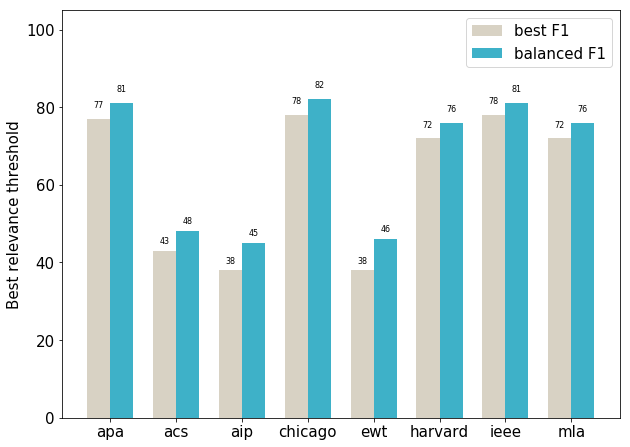

In [10]:
def autolabel(ax, rects):
    for rect in rects:
        plt.rcParams.update({'font.size': 8})
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

def plot_threshold_by_styles(best, balanced, ylim_max, yticks):
    ind = np.arange(len(STYLES))
    width = 0.35
    
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(figsize=(10, 7.5))
    rects1 = ax.bar(ind, best, width, color='#d8d2c4')
    rects2 = ax.bar(ind + width, balanced, width, color='#3eb1c8')

    ax.set_ylabel('Best relevance threshold')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(STYLES_ABR)
    plt.ylim(0, ylim_max)
    plt.yticks(yticks)
    ax.legend((rects1[0], rects2[0]), ('best F1', 'balanced F1'))
    autolabel(ax, rects1)
    autolabel(ax, rects2)
    plt.show()

plot_threshold_by_styles(best_threshold_styles, balanced_threshold_styles, 105, [0, 20, 40, 60, 80, 100])

Unfortunately, there is a lot of variation between the styles. It seems that for the styles with the title the best threshold is roughly twice as high as the best threshold for the styles without the title. This is most likely related to the amount of information available to the search engine when selecting the target document. Large differences in the best thresholds suggest that using a single threshold for every case might not be the best idea, because most of the time the chosen threshold (52) will be far from the true best threshold.

#### Normalized threshold

The idea behind the normalized threshold came from the observation, that relevance scores tend to be higher for longer queries, irrespective of the actual relevance of the returned items.

Let's do a simple test to find out whether the relevance scores are correlated with the query length. We will query the search engine using an example query, and then query it again using the concatenation of the query with itself:

In [11]:
remote_call('https://api.crossref.org/works?' +
            'query.bibliographic=dominika+tkaczyk+cermine&rows=1&select=title,score')[2]

'{"status":"ok","message-type":"work-list","message-version":"1.0.0","message":{"facets":{},"total-results":2384,"items":[{"title":["CERMINE: automatic extraction of structured metadata from scientific literature"],"score":24.900272}],"items-per-page":1,"query":{"start-index":0,"search-terms":null}}}'

In [12]:
remote_call('https://api.crossref.org/works?' +
            'query.bibliographic=dominika+tkaczyk+cermine+dominika+tkaczyk+cermine&rows=1&select=title,score')[2]

'{"status":"ok","message-type":"work-list","message-version":"1.0.0","message":{"facets":{},"total-results":2384,"items":[{"title":["CERMINE: automatic extraction of structured metadata from scientific literature"],"score":49.800545}],"items-per-page":1,"query":{"start-index":0,"search-terms":null}}}'

As we can see, in the second case the relevance score is 100% larger than the score in the first case, even though we simply provided the same query twice, without even passing more information.

Based on this observation, it seems that instead of using a simple threshold, a better approach might be to normalize the relevance score by the length of the reference string before applying the threshold. More precisely, we will apply a threshold to the relevance score divided by the length of the reference string. This function will modify the dataset according to this normalized threshold:

In [13]:
def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(item[dfk.DATASET_REF_STRING]) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Similarly as before, we will calculate the results for a range of different values of the normalized threshold and find out which normalized threshold is the best one:

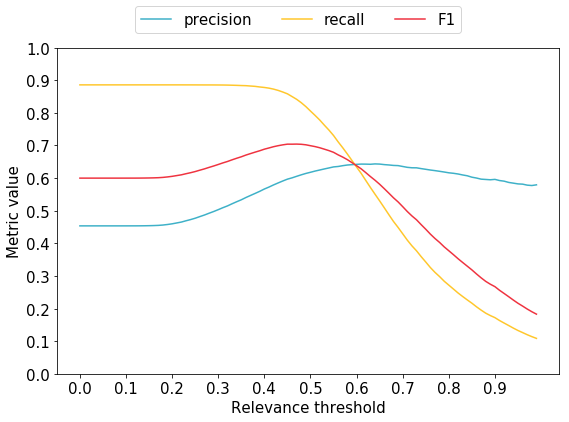

Maximum F1 (0.7043) is for threshold 0.47000000000000003
Precision for this threshold: 0.6055
Recall for this threshold: 0.8416
Best balanced F1 (0.6380) is for threshold 0.6
Precision for this threshold: 0.6422
Recall for this threshold: 0.6339


In [14]:
dataset = read_artificial_data()
results_norm_threshold = [(t, LinkMetricsResults(modify_norm_threshold(dataset, t)))
                          for t in np.arange(0.0, 1.0, 0.01)]
plot_results(results_norm_threshold)
print_best(results_norm_threshold)
print_balanced(results_norm_threshold)

The best value of F1 (70,43%) is achieved by the normalized threshold of 0.47. Note that this time we achieved better F1 than in the case of the simple threshold (67,21%).

Similarly as before, let's also plot the normalized threshold for each style separately.

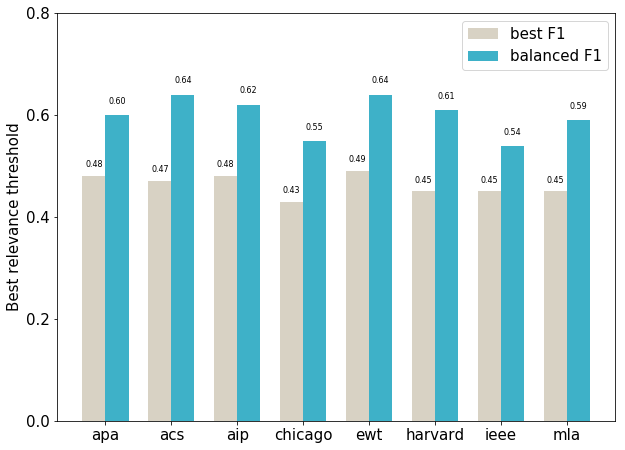

In [15]:
dataset = read_artificial_data()
datasets_styles = [[d for d in dataset if d['style'] == s] for s in STYLES]
results_threshold_norm_styles = \
    [[(t, LinkMetricsResults(modify_norm_threshold(d, t))) for t in np.arange(0.0, 1.0, 0.01)]
     for d in datasets_styles]
best_threshold_norm_styles = [int(find_best(r)[1] * 100)/100.0 for r in results_threshold_norm_styles]
balanced_threshold_norm_styles = [int(find_balanced(r)[1] * 100)/100.0 for r in results_threshold_norm_styles]
plot_threshold_by_styles(best_threshold_norm_styles, balanced_threshold_norm_styles, 0.8, [0, 0.2, 0.4, 0.6, 0.8])

In this case we observe much less variability than in the case of the simple threshold. The best normalized threshold varies in a fairly small range 0.43-0.49. As a result, when we use a single normalized threshold, we are closer to the true threshold, irrespective of the style of the reference string.

#### Comparison of F1

Let's also compare the overall F1 and F1 for each style obtained by two versions of the algorithm: SBM with the best simple threshold and SBM with the best normalized threshold.

Here we have F1s for the best simple threshold (53):

In [16]:
_, threshold_simple, _, _, f1_simple = find_best(results_simple_threshold)
dataset = read_artificial_data()
modify_simple_threshold(dataset, threshold_simple)
styles_simple_f1 = [LinkMetricsResults([d for d in dataset if d['style'] == s]).get(dfk.EVAL_F1) for s in STYLES]

And here we have F1s for the best normalized threshold (0.47):

In [17]:
_, threshold_norm, _, _, f1_norm = find_best(results_norm_threshold)
dataset = read_artificial_data()
modify_norm_threshold(dataset, threshold_norm)
styles_norm_f1 = [LinkMetricsResults([d for d in dataset if d['style'] == s]).get(dfk.EVAL_F1) for s in STYLES]

Let's plot those F1s. Here, the first bar represents overall F1, and the following bars are for individual styles.

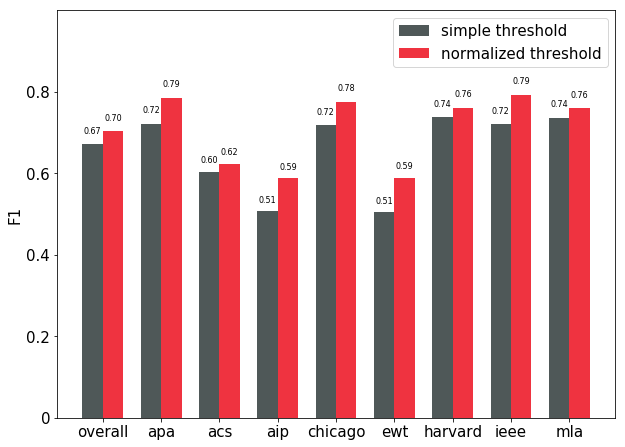

In [18]:
ind = np.arange(len(STYLES) + 1)
width = 0.35

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10, 7.5))
rects1 = ax.bar(ind, [f1_simple] + styles_simple_f1, width, color='#4f5858')
rects2 = ax.bar(ind + width, [f1_norm] + styles_norm_f1, width, color='#ef3340')

ax.set_ylabel('F1')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['overall'] + STYLES_ABR)
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8])
ax.legend((rects1[0], rects2[0]), ('simple threshold', 'normalized threshold'))
autolabel(ax, rects1)
autolabel(ax, rects2)
plt.show()

In all cases applying the best normalized threshold results in higher F1 as compared to applying the best simple threshold. The increase is especially significant in the case of the styles that do not include the title in the reference string (aip, ewt). This confirms that normalized threshold is the better choice.

### Real dataset

The dataset composed of real-life reference strings contains 1000 cases:

In [19]:
def read_real_data():
    return read_json(DATA_DIR + 'existing/existing_sample_1000.json')

dataset = read_real_data()
print('Dataset size: {}'.format(len(dataset)))

Dataset size: 1000


Let's examine the results calculated on the real dataset for a range of simple threshold values:

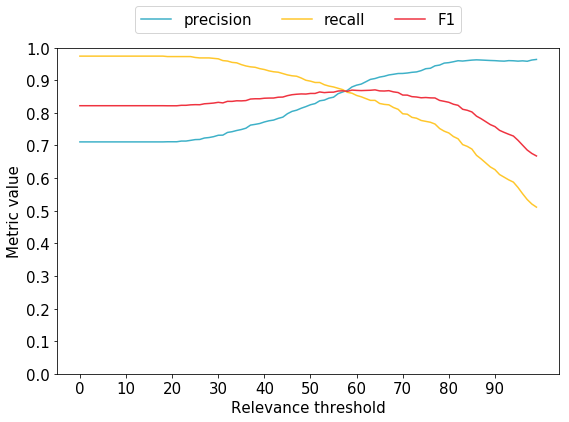

Maximum F1 (0.8706) is for threshold 64
Precision for this threshold: 0.9053
Recall for this threshold: 0.8384
Best balanced F1 (0.8660) is for threshold 58
Precision for this threshold: 0.8690
Recall for this threshold: 0.8630


In [20]:
dataset = read_real_data()
results_threshold = [(threshold, LinkMetricsResults(modify_simple_threshold(dataset, threshold)))
                     for threshold in np.arange(0, 100, 1)]
plot_results(results_threshold)
print_best(results_threshold)
print_balanced(results_threshold)

The best F1 is achieved for threshold of 64. The F1 line is fairly flat, which suggests that in the real dataset the relevance scores of the correct and incorrect cases are quite well separated.

Note that the value of F1 is most likely a bit higher than the true value, due to our assumption that DOIs independently matched by two algorithms are correct. It is probable that in some cases the DOI was incorrect.

Let's also see which normalized threshold is the best for the real dataset:

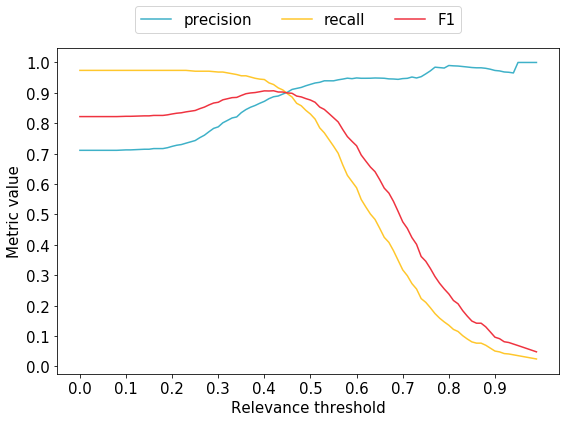

Maximum F1 (0.9069) is for threshold 0.42
Precision for this threshold: 0.8873
Recall for this threshold: 0.9274
Best balanced F1 (0.8997) is for threshold 0.45
Precision for this threshold: 0.9022
Recall for this threshold: 0.8973


In [21]:
dataset = read_real_data()
results_threshold = [(threshold, LinkMetricsResults(modify_norm_threshold(dataset, threshold)))
                     for threshold in np.arange(0.0, 1.0, 0.01)]
plot_results(results_threshold)
print_best(results_threshold)
print_balanced(results_threshold)

In this case, we have the best normalized threshold of 0.42. Similarly as before, F1 for the best normalized threshold is higher than F1 for simple threshold.

Normalized threshold calculated on the real data is fairly close to that calculated on the artificial data.